In [122]:
import numpy as np
from sklearn import svm
from PIL import Image
from torchvision import transforms
to_tensor = transforms.ToTensor()
import os
import glob
from tqdm import tqdm
from disvae.utils.modelIO import load_model
import pandas as pd

In [52]:
# Load in the torch vae models
model_name = "btcvae_cardamage_128_z10"
model_dir = os.path.join("results", model_name)
epoch = 0
# model_epoch = "model-{}".format(epoch) #
vae_model = load_model(model_dir) #, filename=model_epoch)


In [53]:
data_root = "data/car_damage_128"
img_paths = []
for ext in ['.jpg', ".JPEG"]:
    img_paths.extend(glob.glob(os.path.join(data_root, "*/*" + ext)))

In [96]:
Z = list()
y = np.empty(shape=len(img_paths), dtype=int)
for i, img_path in tqdm(enumerate(img_paths)):
    img = to_tensor(Image.open(img_path))
    img = img.unsqueeze(0)
    z_mean, z_log_var = vae_model.encoder.forward(img)
    z_mean = np.squeeze(z_mean.detach().numpy())
    Z.append(z_mean)
    label = img_path.split('/')[2] # expected path structure: data/<dataset>/<label>/<file>
    label = 0 if label == "Real" else 1
    y[i] = label
Z = np.array(Z)

2035it [00:06, 337.18it/s]


In [213]:
# Train an SVM to classify the latent space between real and fake images from car damage dataset
svm_model = svm.SVC()
Cs = [2**x for x in range(-5,15)]
gammas = [2**x for x in range(-15,3)]
svm_model = GridSearchCV(svm_model, param_grid={'C': Cs, "gamma": gammas})

In [214]:
svm_model.fit(Z,y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32, 64, 128, 256, 512, 1024, 2048, 4096,
                               8192, 16384],
                         'gamma': [3.0517578125e-05, 6.103515625e-05,
                                   0.0001220703125, 0.000244140625,
                                   0.00048828125, 0.0009765625, 0.001953125,
                                   0.00390625, 0.0078125, 0.015625, 0.03125,
                                   0.0625, 0.125, 0.25, 0.5, 1, 2, 4]})

In [205]:
# NuSVM hyperparameters
hparams = {
    "nu": .1,  # must be in interval [0,1]
    "kernel": 'linear' # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
#     degree=3 # only used when kernel='poly'. Degree of the polynomial kernel
}
nusvm_model = svm.NuSVC(**hparams)

In [193]:
from sklearn.model_selection import GridSearchCV

In [208]:
cv_nusvm = GridSearchCV(nusvm_model, {"nu":nus})

In [202]:
nus = []
nus

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [209]:
cv_nusvm.fit(Z,y)

GridSearchCV(estimator=NuSVC(kernel='linear', nu=0.1),
             param_grid={'nu': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})

In [212]:
cv_nusvm.score(Z,y)

0.7095823095823096

In [204]:
nusvm_model.fit(Z, y)

TypeError: fit() got an unexpected keyword argument 'nu'

In [191]:
svm_model.fit(Z, y)

SVC()

In [120]:
nusvm_model.score(Z,y)

0.6398034398034398

In [192]:
svm_model.score(Z,y)

0.7911547911547911

In [152]:
cols = ['z_'+str(i) for i in range(Z.shape[1])] + ['y']

['z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'y']

In [127]:
np.expand_dims(y, axis=1).shape, Z.shape

((2035, 1), (2035, 10))

In [136]:
y_exp = np.expand_dims(y, axis=1)
data = np.concatenate((Z,y_exp), axis=1)

In [215]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

df = pd.DataFrame(data, columns=cols)

m =TSNE(learning_rate=100)

<AxesSubplot:xlabel='tsne_x', ylabel='tsne_y'>

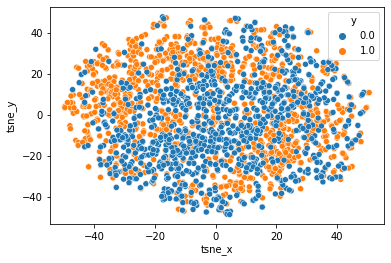

In [189]:
tsne_features = m.fit_transform(df)

df["tsne_x"] = tsne_features[:,0]
df["tsne_y"] = tsne_features[:,1]

sns.scatterplot(x='tsne_x', y='tsne_y', data=df, hue='y')